In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from xgboost import plot_importance

# Data

In [2]:
df = pd.read_csv("imiona.csv")

In [3]:
df.columns

Index(['Imię', 'Liczba', 'Płeć'], dtype='object')

In [4]:
df.rename(columns = {"Imię": "Name", "Liczba": "Count", "Płeć": "Sex"}, inplace = True)

In [5]:
df.columns

Index(['Name', 'Count', 'Sex'], dtype='object')

# EDA

In [6]:
df.isnull().sum()

Name     0
Count    0
Sex      0
dtype: int64

In [7]:
df["Name"].value_counts()

MARCELA     1
HIERONIM    1
BOHDAN      1
WITOLD      1
ROGER       1
           ..
GRETA       1
DEMIAN      1
LIVIA       1
LUCAS       1
ELIZA       1
Name: Name, Length: 1017, dtype: int64

In [8]:
df["Count"].value_counts()

2       238
3        95
4        65
5        45
6        31
       ... 
212       1
1250      1
227       1
229       1
693       1
Name: Count, Length: 257, dtype: int64

In [9]:
df["Sex"].value_counts()

K    514
M    503
Name: Sex, dtype: int64

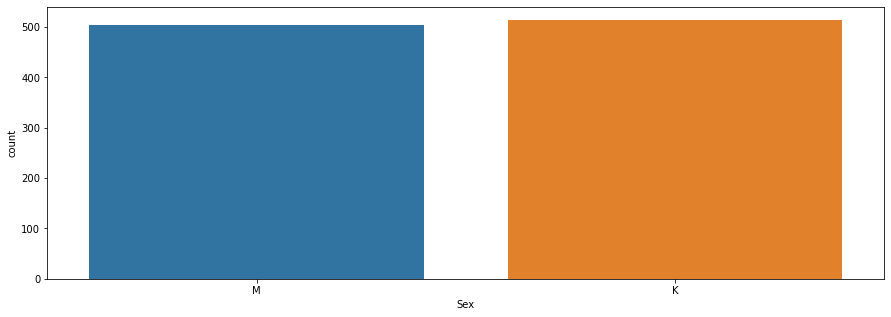

In [10]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(15, 5))
sns.countplot("Sex", data = df);

# Feature Engineering

In [11]:
df

,Name,Count,Sex
0,ANTONI,3862,M
1,JAN,3535,M
2,ALEKSANDER,3353,M
3,FRANCISZEK,3252,M
4,JAKUB,3236,M
...,...,...,...
1012,WIOLETA,2,K
1013,WIRGINIA,2,K
1014,YASMIN,2,K
1015,ZŁATA,2,K


In [12]:
def last_is_a(name):
    if name[-1].lower() == "a":
        return 1
    else:
        return 0
    
# def last_is_ina(name):
#     if name[-3:].lower() == "ina":
#         return 1
#     else:
#         return 0

In [13]:
df["last_a"] = df["Name"].map(last_is_a)
# df["last_is_ina"] = df["Name"].map(last_is_ina)

In [14]:
df[df["Name"] == "ALEKSANDRA"]

,Name,Count,Sex,last_a
520,ALEKSANDRA,1472,K,1


In [15]:
# df[df["Name"] == "JÓZEFINA"] #no effects

In [16]:
vowels = ['a', 'ą', 'e', 'ę', 'i', 'o', 'u', 'y']

def how_many_vowels(name):
    return sum( map(lambda x: int(x in vowels), name.lower()) )
    
def first_is_vowel(name):
    return name.lower()[0] in vowels

def last_is_vowel(name):
    return name.lower()[-1] in vowels

def get_all_vowels(name):
    all_vowels = [letter for letter in name.lower() if letter in vowels]
    
    return ''.join(all_vowels)

def get_all_consonants(name):
    all_consonants = [letter for letter in name.lower() if letter not in vowels]
    
    return ''.join(all_consonants)

def feature_engineering(df):
    df['len_name'] = df['Name'].map(lambda x: len(x))
    
    df['first_is_vowel'] = df['Name'].map(first_is_vowel)
    df['last_is_vowel'] = df['Name'].map(last_is_vowel)
    
    df['first_letter'] = df['Name'].map(lambda x: x.lower()[0])
    df['first_letter_cnt'] = pd.factorize(df['first_letter'])[0]
    
    df['last_letter'] = df['Name'].map(lambda x: x.lower()[-1])
    df['last_letter_cnt'] = pd.factorize(df['last_letter'])[0]
    
    df['all_vowels'] = df['Name'].map(get_all_vowels)
    df['all_vowels_cnt'] = pd.factorize(df['all_vowels'])[0]

    df['all_consonants'] = df['Name'].map(get_all_consonants)
    df['all_consonants_cnt'] = pd.factorize(df['all_consonants'])[0]
    
    
    return df  

In [17]:
df = feature_engineering(df.copy())

# Data processing

In [18]:
#creating objects' list
list_objects = df.select_dtypes('object').columns

#changing values with LabelEncoder
for column in list_objects:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Model

In [19]:
#defining dataset
X = df.drop(["Sex"], axis = 1)
y = df.Sex.values

In [20]:
def run_model(model, variables, target):
    
    #define dataset
    X = variables
    y = target
    
    #splitting data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    #model fit
    model.fit(X_train, y_train)
    
    #scores
    print(f'Train score: {model.score(X_train, y_train)}, Test score: {model.score(X_test, y_test)}\n')
    
#     # evaluate performance
#     y_pred = model.predict(X_test)
#     score = accuracy_score(y_test, y_pred)
#     print('Accuracy: %.3f' % score)
    
    #plot learning curve
    skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='accuracy');
    
    #classification report
    test_hypotheses = model.predict(X_test)
    print(classification_report(test_hypotheses, y_test))
    
    #confusion matrix
    cm = confusion_matrix(test_hypotheses, y_test)
    plot_confusion_matrix(cm)
    
    #feature importances
    plot_importance(model)
    plt.show();

Train score: 1.0, Test score: 0.9803921568627451

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       103
           1       0.96      1.00      0.98       101

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204



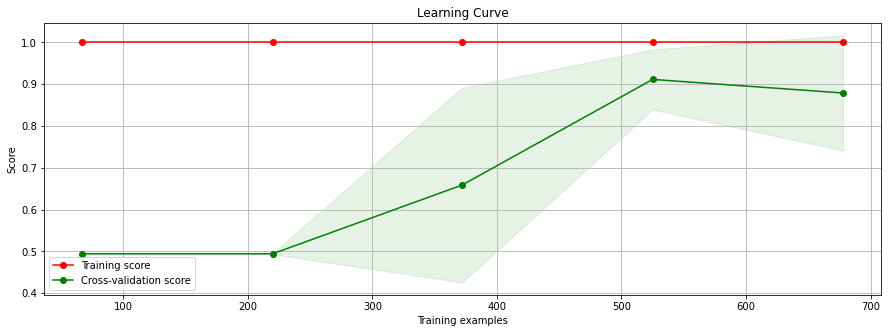

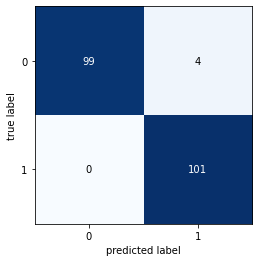

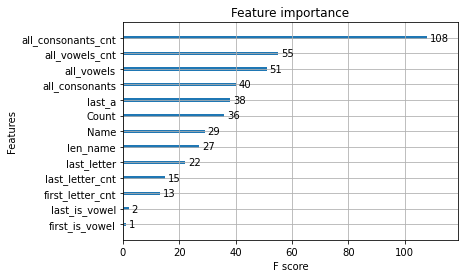

In [21]:
model = xgb.XGBClassifier(eval_metric='mlogloss')
run_model(model, X, y)

# Checking wrong predictions

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
y_pred = model.predict(X_test)

In [23]:
y_pred == y_test

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
df = pd.read_csv("imiona.csv")
df.rename(columns = {"Imię": "Name", "Liczba": "Count", "Płeć": "Sex"}, inplace = True)
#defining dataset
X = df.drop(["Sex"], axis = 1)
y = df.Sex.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
X_test.iloc[5:6]

,Name,Count
908,ARMINA,2


In [26]:
X_test.iloc[11:12]

,Name,Count
657,JÓZEFINA,28


In [27]:
X_test.iloc[32:33]

,Name,Count
616,JUSTYNA,65


In [28]:
X_test.iloc[47:48]

,Name,Count
209,IWAN,12
